In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
from IPython.display import display
import threading
import cv2
import numpy as np
from enum import Enum
from collections import deque
import imutils
import time
import json

from balltracker_app import *
from videoplayer import *

In [139]:
test = BallTracker(source='../../../videos/vincent_court.mp4',
                   data_path='vincent_court.json')
#test = BallTracker(source=0)
test.start(threaded=True)

started


In [30]:
test.load_config(path='vincent_court.json')

In [35]:
test.save_config(path='vincent_court.json')

In [10]:
test.start_data()

In [11]:
test.stop_data()

In [12]:
test.save_balls(path='vincent_court.json')

In [9]:
list(test.balls['Vert'].data.items())

[(0.0, (660, 641)),
 (16.666666666666668, (657, 607)),
 (33.333333333333336, (654, 575)),
 (50.0, (651, 545)),
 (66.66666666666667, (647, 517)),
 (83.33333333333334, (643, 490)),
 (100.0, (639, 466)),
 (116.66666666666667, (636, 444)),
 (133.33333333333334, (632, 424)),
 (150.0, (628, 406)),
 (166.66666666666669, (623, 390)),
 (183.33333333333334, (619, 378)),
 (200.0, (615, 368)),
 (216.66666666666669, (611, 360)),
 (233.33333333333334, (607, 354)),
 (250.0, (603, 350)),
 (266.6666666666667, (600, 347)),
 (283.3333333333333, (596, 346))]

In [14]:
def detect_duplicate_frames(path): #fonctionne pas :(
    vp = VideoPlayer(path)
    if vp.video_type == VideoType.WEBCAM:
        print("Impossible avec webcam.")
        return
    vp.loop = False
    duplicated_frames = []
    ret, last_frame = vp.read()
    i = 0
    while True:
        i += 1
        ret, frame = vp.read()
        #print(ret, end=' ')
        if not ret:
            break
        #print(np.sum(frame - last_frame), end=' ')
        """if np.array_equal(frame, last_frame):
            duplicated_frames.append(i)"""
        last_frame = frame
        cv2.imshow('duplicate_frames', frame)
        cv2.waitKey(0)
    vp.release()
    cv2.destroyAllWindows()
    return duplicated_frames

In [66]:
import matplotlib.pyplot as plt
from balltracker_app import *
from math import isnan

def untuplize(l, python_list=False):
    #l est une liste de tuples de même longueur.
    if len(l) == 0:
        return ()
    if not python_list:
        return tuple(np.array([elem[i] for elem in l]) for i in range(len(l[0])))
    else:
        return tuple([elem[i] for elem in l] for i in range(len(l[0])))
    
"""def tuplize(*args):
    #args est fait de listes toute de même longueur
    if len(args) == 0:
        return []
    return [tuple(arg[i] for arg in args) for i in range(len(args[0]))]"""

def threshold_intersections(threshold, x, y, interpolate=True):
    inter = []
    i_inter = []
    for i in range(len(x) - 1):
        #Vérifie si le seuil est atteint
        #Notons que y[i] est toujours strictement différent du seuil.
        if y[i] < threshold <= y[i+1] or y[i] > threshold >= y[i+1]:
            #Trouve le point d'intersection
            if interpolate:
                t_inter = (threshold * (x[i+1] - x[i]) - (x[i+1]*y[i] - x[i]*y[i+1])) / (y[i+1] - y[i])
            else:
                t_inter = x[i] 
            inter.append(t_inter)
            i_inter.append(i)
    return inter, i_inter

In [178]:
l = [1, 2, 3, 4]
del l[:2]
l

[3, 4]

In [191]:
%matplotlib notebook

#ON NE GERE PAS ENCORE LES PROBLEME LIES A ABSENCE DE VALEUR !
#Problèmes acces valeurs en 0 dans init tableaux. A resoudre plus tard

def plot_data(path, ignore_nan = False):
    with open(path, 'r') as f:
        data = json.load(f)
    balls = [Ball.from_dict(ball_data) for ball_data in data['balls']]
    thresholds = data['thresholds']
    thresholds[1] = -thresholds[1]
    
    #temps en ms
    to_plot = [{"x" : "t",   "y" : "x",  "xlabel" : "temps", "ylabel" : "x",  "threshold" : thresholds[0]},
               {"x" : "t",   "y" : "y",  "xlabel" : "temps", "ylabel" : "y",  "threshold" : thresholds[1]},
               #{"x" : "tv",  "y" : "vx", "xlabel" : "temps", "ylabel" : "vx"},
               {"x" : "tv",  "y" : "vy", "xlabel" : "temps", "ylabel" : "vy", "threshold" : 0}]
               #{"x" : "ta", "y" : "ax",  "xlabel" : "temps", "ylabel" : "ax"},
               #{"x" : "ta", "y" : "ay",  "xlabel" : "temps", "ylabel" : "ay"}]
    
    fig, axes = plt.subplots(len(to_plot), 1, figsize=(12, 5*len(to_plot)))
    
    for ball in balls:
        if ball.name != "Vert":
            continue
        ball_data_list = [(key, *elem) for key, elem in ball.data.items()]
        ball_data_list.sort(key = lambda x : x[0])
        t, x, y = untuplize(ball_data_list)
        t_list = list(t)
        if ignore_nan:
            #On suppose x nan ssi y nan
            #Ceci est un moyen étrange mais fonctionnel de retirer les nan.
            mask = (x <= float('infinity'))
            t, x, y = t[mask], x[mask], y[mask]
        y = -y
                    
        dt = t[1:] - t[:-1]
        dt2 = dt[:-1]
        tv = t[:-1]
        ta = t[:-2]
        vx = (x[1:] - x[:-1]) / dt
        vy = (y[1:] - y[:-1]) / dt
        ax = (vx[1:] - vx[:-1]) / dt2
        ay = (vy[1:] - vy[:-1]) / dt2
        var = {"t" : t, "tv" : tv, "ta" : ta, "x" : x, "y" : y, "vx" : vx, "vy" : vy,
               "ax" : ax, "ay" : ay}
        
        ##TEST
        #Si le tracking coupe au moment ou la barre est passé... non detecté :(
        #Possible de le faire en utilisant ignore nan !
        thr_x, thr_y = thresholds
        
        x_inter, i_x_inter = threshold_intersections(thr_x, t, x)
        axes[0].scatter(x_inter, [thr_x]*len(x_inter), marker='x', color=ball.plt_color)
        
        vx_inter, i_vx_inter = threshold_intersections(0, tv, vx)
        
        #Les lancers en x sont les plus simples à identifier, on ne considère que le point où le seuil
        #est traversé (et pas la durée du trajet, qui est determinée par les mouvements en y).
        i_x_throws = i_x_inter
        
        #Si jamais le premier/dernier lancé est incomplet, on ne le prend pas en compte.
        #On peut déterminer cela en examinant s'il y a un point d'intéret précédant le premier lancer en x.
        #(lancer en x = seuil franchi en x)
        #En effet, un point d'intéret est ou bien une vitesse nulle, ou bien une valeur nan,
        #indiquant respectivement que la balle vient d'être lancée, ou qu'elle était cachée au lancement,
        #mais a donc bel et bien été lancée.
        
        #On recherche les points nan.
        nan_streak = False
        i_nan = []
        for i, elem in enumerate(vx):
            if isnan(elem) and not nan_streak:
                nan_streak = True
                if i != 0:
                    i_nan.append(i-1)
            elif not isnan(elem) and nan_streak:
                nan_streak = False
                i_nan.append(i)
        
        #POI = Point Of Interest
        i_x_poi = sorted(list(set(i_vx_inter + i_nan)))

        #On examine si le premier lancer est complet
        if i_x_poi[0] > i_x_throws[0]:
            i_x_throws.pop(0)
        #Idem pour le dernier
        if i_x_poi[-1] < i_x_throws[-1]:
            i_x_throws.pop(-1)
        
        #On s'occupe des lancer en y.
        y_inter, i_y_inter = threshold_intersections(thr_y, t, y)
        axes[1].scatter(y_inter, [thr_y]*len(y_inter), marker='x', color=ball.plt_color)
        
        vy_inter, i_vy_inter = threshold_intersections(0, tv, vy)
        
        #On regroupe les lancers par deux pour obtenir des cloches.
        i_bells = []
        above_threshold = y[0] > thr_y
        i_bell_start = None
        for i in range(len(y) - 1):
            new_above_threshold = y[i] > thr_y
            if not(above_threshold) and new_above_threshold:
                i_bell_start = i
            elif above_threshold and not(new_above_threshold):
                if i_bell_start is None:
                    continue
                i_bells.append((i_bell_start, i))
                i_bell_start = None    
            above_threshold = new_above_threshold
        print(f"{i_bells = }")
        #On regroupe les lancers par deux pour obtenir des cloches.
        #Fonctionne au vu de threshold_intersections et de stricte inégalité y_inter par rapport à thr_y
        """i_bells = []
        for i in range(len(i_y_inter) - 1):
            if y[i_y_inter[i]] < thr_y and y[i_y_inter[i+1]] > thr_y:
                i_bells.append((i_y_inter[i], i_y_inter[i+1]))"""
        #print(f"{i_bells = }")

        #On souhaite également prendre en compte les moment où l'on perd/récupère les valeurs comme début/fin de cloche
        nan_streak = False
        i_nan = []
        for i, elem in enumerate(vy):
            if isnan(elem) and not nan_streak:
                nan_streak = True
                if i != 0:
                    i_nan.append(i-1)
            elif not isnan(elem) and nan_streak:
                nan_streak = False
                i_nan.append(i) 

        i_bell_limit_poi = sorted(list(set(i_nan + i_vy_inter)))
        print(f"{i_bell_limit_poi = }")
        axes[2].scatter([t[i] for i in i_bell_limit_poi], [vy[i] for i in i_bell_limit_poi], marker='x', color=ball.plt_color)
        
        #Si la première cloche arrive trop tôt, il se peut qu'on ne connaisse pas son début.
        #Dans ce cas, il faut penser à examiner précautionneusement le premier lancer en x,
        #qui peut correspondre au même lancer en y.
        #2 cas se présentent.
        #  1) La première/dernière cloche est en fait incomplète, car n'a franchie qu'une fois le seuil.
        #  2) On n'a pas de poi avant la premiere cloche/après la dernière.
        #Dans les 2 cas, il faut examiner s'il n'y a pas de lancer x associé à ces lancers y.
        #Si on ne les supprime pas, ils seraient considérés à tord comme des lancers de 1.
        """if i_bell_limit_poi[0] > i_bells[0][0]:
            i_bells.pop(0)
            i = 0
            while i < len()
        #Idem pour la dernière cloche
        if i_bell_limit_poi[-1] < i_bells[-1][1]:
            i_bells.pop(-1)"""
        i_y_inter_in_bell = untuplize(i_bells, python_list=True)
        careful_x_start = None
        careful_x_end = None
        #Cas 1 - Cloche incomplète. Le cas 1 exclue le cas 2.
        if i_y_inter[0] not in i_y_inter_in_bell:
            careful_x_start = i_y_inter[0]
        if i_y_inter[-1] not in i_y_inter_in_bell:
            careful_x_end = i_y_inter[-1]     
        #Idem pour la dernière cloche
        if i_bell_limit_poi[-1] < i_bells[-1][1]:
            i_bells.pop(-1)
        #Cas 2 - Pas de POI
        if i_bells[0][0] < i_bell_limit_poi[0]:
            i_bells.pop(0)
            careful_x_start = i_bells[0][1]
        if i_bells[-1][1] > i_bell_limit_poi[-1]:
            i_bells.pop(-1)
            careful_x_end = i_bells[-1][0]
        
        #On cherche les poi jusqu'auxquels on doit faire attention :
        i = 0
        while i < len(i_bell_limit_poi) and i_bell_limit_poi[i] <= i_y_inter[0]:
            i += 1
        if i == len(i_bell_limit_poi):
            critical_i = float('inf')
        else:
            critical_i = i_bell_limit_poi[i]
        #Puis on supprime les lancers de x problématiques :
        i = 0
        while i < len(i_x_throws) and i_x_throws[i] < critical_i:
            i += 1
        del i_x_throws[:i]
        #idem pour la fin:
        i = 0
        while i < len(i_bell_limit_poi) and i_bell_limit_poi[len(i_bell_limit_poi)-i-1] >= i_y_inter[-1]:
            i += 1
        if i == len(i_bell_limit_poi):
            critical_i = -float('inf')
        else:
            critical_i = i_bell_limit_poi[len(i_bell_limit_poi)-i-1]
        i = 0
        while i < len(i_x_throws) and i_x_throws[len(i_x_throws)-i-1] > critical_i:
            i += 1
        del i_x_throws[len(i_x_throws)-i:]
        
        print(f"{i_bells = }")
        
        #On peut à présent se pencher sur les cloches !
        #Pour chaque cloche, on cherche les temps de lancer et de réception
        i_y_throws = []
        i_throw_start = None
        i_poi = 0 #poi = point of interest
        for i_bell_start, i_bell_end in i_bells:
            #Début de la courbe
            while i_poi < len(i_bell_limit_poi) and i_bell_limit_poi[i_poi] < i_bell_start:
                i_poi += 1
            if i_poi == len(i_bell_limit_poi):
                break
            #on est assuré que i_poi>1 car on a supprimé la première cloche sinon
            i_throw_start = i_bell_limit_poi[i_poi - 1]
            #Fin de la courbe
            while i_poi < len(i_bell_limit_poi) and i_bell_limit_poi[i_poi] < i_bell_end:
                i_poi += 1
            if i_poi == len(i_bell_limit_poi):
                break
            i_throw_end = i_bell_limit_poi[i_poi]
            #On enregistre les vols de balle pour la courbe.
            i_y_throws.append((i_throw_start, i_throw_end))
        
        #On affiche les débuts/fins de cloches.
        i_y_starts, i_y_ends = untuplize(i_y_throws, python_list=True)
        print(f"{i_y_starts = }", f"{i_y_ends = }")
        t_starts = [t[i] for i in i_y_starts]
        t_ends = [t[i] for i in i_y_ends]
        y_starts = [y[i] for i in i_y_starts]
        y_ends = [y[i] for i in i_y_ends]
        axes[1].scatter(t_starts, y_starts, marker='^', color=ball.plt_color)
        axes[1].scatter(t_ends  , y_ends  , marker='v', color=ball.plt_color)
            
        
        
        #On cherche quels lancers en x et en y font en fait partie du même lancer.
        #On suppose qu'un lancer en x ne peut pas passer deux fois par le seuil vertical au cours du même lancer.
        #Element de throw : (time, origin, destination, "=1") ou (time, origin, destination, ">1", length)
        #Changer de structure de donnée plus tard (namedtuple ou class à part entiere ?)
        throws = [] 
        assigned_x_throws = [False]*len(i_x_throws)
        for i_y_start, i_y_end in i_y_throws:
            throw_found = False
            for i, i_x in enumerate(i_x_throws):
                if i_y_start < i_x < i_y_end:
                    #Cas d'un lancer d'une main à l'autre de hauteur > 1
                    # Main 0 = notre gauche = main droite du jongleur
                    # Main 1 = notre droite = main gauche du jongleur
                    # On peut l'identifier comme ça grâce à la fonction threshold_intersections.
                    origin = 0 if x[i_x] < thr_x else 1
                    destination = 1 - origin
                    i_length = i_y_end - i_y_start
                    throws.append((i_y_start, origin, destination, ">1", i_length))
                    
                    #On quitte la boucle, et dit que ce lancer en x est attribué
                    throw_found = True
                    assigned_x_throws[i] = True
                    break
                    
            if not throw_found:
                #Cas d'un lancer dans la même main de hauteur > 1
                origin = 0 if x[i_x] < thr_x else 1
                destination = origin
                length = i_y_end - i_y_start
                throws.append((i_y_start, origin, destination, ">1", i_length))
                
        for i, i_x in enumerate(i_x_throws):
            if not assigned_x_throws[i]:
                #Cas d'un lancer d'une main à l'autre de hauteur = 1
                origin = 0 if x[i_x] < thr_x else 1
                destination = 1 - destination
                throws.append((i_x, origin, destination, "=1"))
        
        throws.sort(key = lambda x : x[0])
        print(f"{throws = }")
                
            
        for i, data in enumerate(to_plot):
            axes[i].plot(var[data['x']], var[data['y']], color=ball.plt_color, label=ball.name)
        #ax[0].plot(t, x, color=ball.plt_color, label=ball.name)
        #plt.figlegend()
        
    for i, data in enumerate(to_plot): #DOUBLE UTILISATION DE DATA A CORRIFER ?
        if 'xlabel' in data:
            axes[i].set_xlabel(data['xlabel'])
        if 'ylabel' in data:
            axes[i].set_xlabel(data['ylabel'])
        axes[i].set_xticks(data.get('xticks', np.linspace(t[0], t[-1], 5))) #a corriger
        if 'threshold' in data:
            axes[i].plot(axes[i].get_xlim(), [data['threshold']]*2, linestyle='--')
    #A CONFIGURER ABSOLUMENT sinon la figure met des années à s'afficher
    #ax[0].set_xticks(np.linspace(int(t[0]), t[-1], 5))

    #Résoudre décalage de 1 sur triangles !!
    

<IPython.core.display.Javascript object>


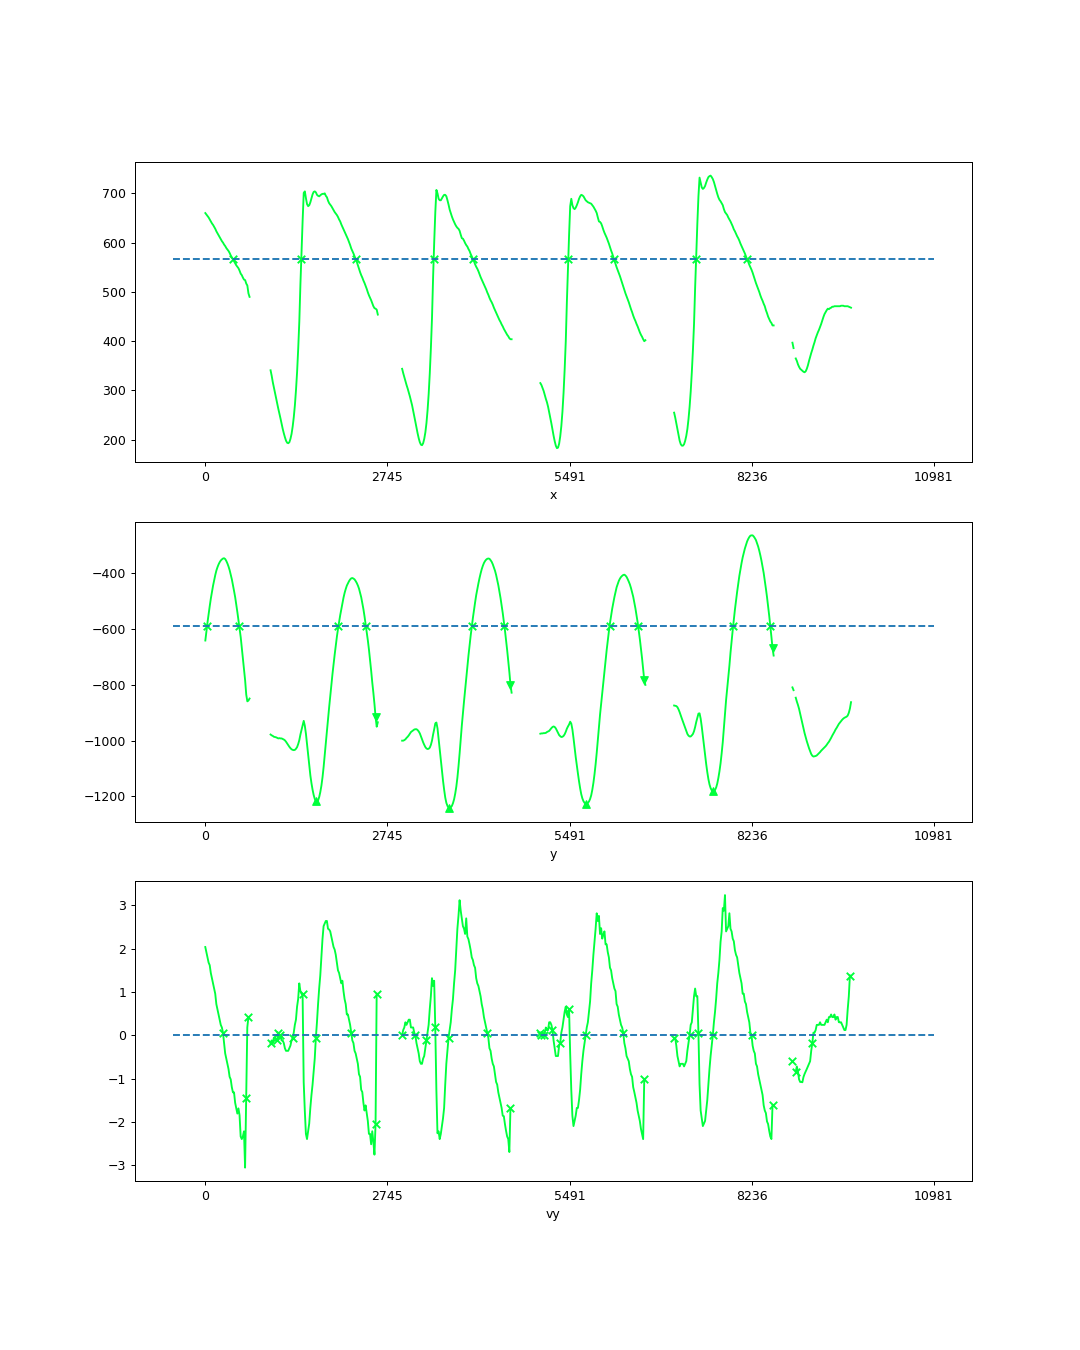

i_bells = [(2, 31), (121, 146), (242, 271), (366, 392), (478, 512)]
i_bell_limit_poi = [16, 37, 39, 59, 65, 66, 68, 79, 88, 100, 132, 154, 155, 178, 190, 200, 208, 220, 255, 276, 303, 304, 306, 314, 321, 329, 344, 378, 397, 424, 438, 446, 459, 494, 513, 531, 534, 549, 583]
i_bells = [(121, 146), (242, 271), (366, 392), (478, 512)]
i_y_starts = [100, 220, 344, 459] i_y_ends = [154, 276, 397, 513]
throws = [(86, 0, 1, '=1'), (100, 1, 0, '>1', 54), (206, 0, 0, '=1'), (220, 1, 0, '>1', 56), (328, 0, 1, '=1'), (344, 1, 0, '>1', 53), (443, 0, 0, '=1'), (459, 1, 0, '>1', 54)]


In [192]:
plot_data('vincent_court.json', ignore_nan=False)

In [68]:
path = 'test_train.json'
with open(path, 'r') as f:
    data = json.load(f)
balls = [Ball.from_dict(ball_data) for ball_data in data]
#fig, ax = plt.subplots(2, 1)

In [69]:
ball = balls[0]
for key, elem in ball.data.items():
    if not isinstance(elem, list):
        print(key)

9800.0


In [72]:
ball.data

{'66.66669999994338': [306, 329],
 '100.0': [307, 327],
 '133.33330000005662': [306, 329],
 '166.66669999994338': [304, 331],
 '200.0': [300, 330],
 '233.33330000005662': [299, 331],
 '266.6666999999434': [296, 341],
 '300.0': [295, 328],
 '333.3333000000566': [296, 320],
 '366.6666999999434': [297, 326],
 '400.0': [300, 327],
 '433.3333000000566': [302, 329],
 '466.6666999999434': [303, 326],
 '500.0': [305, 318],
 '533.3333000000566': [308, 326],
 '566.6666999999434': [313, 324],
 '600.0': [318, 318],
 '633.3333000000566': [325, 317],
 '666.6666999999434': [331, 327],
 '700.0': [338, 330],
 '733.3333000000566': [333, 329],
 '766.6666999999434': [343, 326],
 '800.0': [346, 320],
 '833.3333000000566': [335, 326],
 '866.6666999999434': [316, 350],
 '900.0': [312, 349],
 '933.3333000000566': [311, 347],
 '966.6666999999434': [311, 347],
 '1000.0': [304, 355],
 '1033.3333000000566': [308, 324],
 '1066.6666999999434': [304, 330],
 '1100.0': [297, 330],
 '1133.3333000000566': [292, 326],
 '

In [ ]:
b = widgets.Dropdown(options=[1, 2, 3])
b.observe(lambda change : print(change), names="value")
display(b)

In [130]:
b.options = [1, 2, 3, 4]

In [131]:
 b.value = 2

{'name': 'value', 'old': 1, 'new': 2, 'owner': Dropdown(index=1, options=(1, 2, 3, 4), value=2), 'type': 'change'}


In [ ]:
a = Test()
b = Test()
print({"a":a, "b":b})

In [ ]:
isinstance(Mode.QUIT, Mode)

In [88]:
debug_view

Output(layout=Layout(border='1px solid black'), outputs=({'output_type': 'stream', 'text': "{'JV': {'lower_hsv…

In [17]:
class Test:
    def __init__(self):
        self.button = widgets.Button(layout={'width': '300px'})
        self.button.on_click(lambda b: self.oups())
        self.i = 0
    
    @debug_view.capture(clear_output=True)
    def oups(self):
        print('This is about to explode')
        tmp = 1.0 / 0.0
    
    def print_sleep(self):
        time.sleep(5.0)
        print('thread ', self.i)
    
    def start_thread(self):
        thread = threading.Thread(target = self.print_sleep)
        thread.start()
        print('started ', self.i)
    
    def display(self):
        display(self.button)
    
    def __repr__(self):
        return str(self.i)

a = Test()
a.start_thread()

started  0


In [18]:
a.i = 10

thread  10


In [82]:
debug_view

Output(layout=Layout(border='1px solid black'), outputs=({'output_type': 'stream', 'text': 'This is about to e…

In [ ]:
#A rendre fonctionnel un jour avec des vidéos (en plus de webcam)
debug_view = widgets.Output(layout={'border': '1px solid black'})

@debug_view.capture(clear_output=True)
def bad_callback(event):
    print('This is about to explode')
    return 1.0 / 0.0

button = widgets.Button(
    description='click me to raise an exception',
    layout={'width': '300px'}
)
button.on_click(bad_callback())
button

In [ ]:
debug_view